# Collaborative Filtering based Movie Recomendation System using KNN

In [20]:
# importing necessary libraries

import os  # operating system-dependent functionalities
import numpy as np # support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions
import pandas as pd # provides data structures and data analysis tools
import matplotlib.pyplot as plt # plotting library for creating static, animated, and interactive visualizations
from sklearn.neighbors import NearestNeighbors
from collections import Counter

## Creating Dataframes and cleaning data

The first step of movie recommendation system is to gather relevant data. For this project I found a movie rating dataset that is publicly availabe on Kaggle

In [21]:
# importing ratings dataset into a dataframe
ratings_df = pd.read_csv("dataset/ratings_small.csv")

In [84]:
# number of rows, and columns in dataframe ratings_df
ratings_df.shape

(100004, 4)

In [85]:
# first five rows of ratings_df
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [24]:
# Checking null values in ratings_df
null_counts_ratings = ratings_df.isnull().sum()
print(null_counts_ratings)

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [25]:
# Checking invalid values in ratings column
invalid_ratings_count = ((ratings_df['rating'] < 0) | (ratings_df['rating'] > 5)).sum()
print(f"The number of rows with 'rating' outside the range of 0 to 5 is: {invalid_ratings_count}")

The number of rows with 'rating' outside the range of 0 to 5 is: 0


In [26]:
# importing movie dataset into a dataframe
movie_df = pd.read_csv("dataset/movies_metadata.csv")
movie_df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23488\1289453489.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_df = pd.read_csv("dataset/movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [86]:
# renaming column id in movie_df to movieId
movie_df.rename(columns={'id': 'movieId'}, inplace=True)
movie_df.head()

,movieId,title,genres
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]"


In [28]:
# Keeping only title and genres columns
movie_cols = ['movieId','title', 'genres']
movie_df = movie_df[movie_cols]
movie_df.head()

,movieId,title,genres
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]"


In [29]:
# Checking null values in movie_df
null_counts_movies = movie_df.isnull().sum()
print(null_counts_movies)

movieId    0
title      6
genres     0
dtype: int64


In [30]:
# Dropping rows with null title values
movie_df = movie_df.dropna()

In [31]:
# Convert 'movieId' column to numeric, coercing errors to NaN
movie_df['movieId'] = pd.to_numeric(movie_df['movieId'], errors='coerce')

# Drop rows with NaN values in the 'movieId' column
movie_df = movie_df.dropna(subset=['movieId'])


## Merging two dataFrames into one

In [32]:
# Convert the 'movieId' column in movie_df to int64
movie_df['movieId'] = movie_df['movieId'].astype('int64')

In [33]:
# combining these dataframes on the common column movieID
movie_ratings = ratings_df.merge(movie_df, on='movieId')
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1371,2.5,1260759135,Rocky III,"[{'id': 18, 'name': 'Drama'}]"
1,1,1405,1.0,1260759203,Greed,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name..."
2,1,2105,4.0,1260759139,American Pie,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
3,1,2193,2.0,1260759198,My Tutor,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,1,2294,2.0,1260759108,Jay and Silent Bob Strike Back,"[{'id': 35, 'name': 'Comedy'}]"


In [34]:
# Remove duplicate entries based on 'userId' and 'movieId'
movie_ratings = movie_ratings.drop_duplicates(subset=['userId', 'movieId'])

In [35]:
num_rows = movie_ratings.shape[0]
print("Number of rows:", num_rows)

num_cols = movie_ratings.shape[1]
print("Number of columns:", num_cols)

Number of rows: 44989
Number of columns: 6


In [36]:
unique_movies = movie_ratings['movieId'].nunique()
print("Number of unique movies:", unique_movies)

Number of unique movies: 2830


## Exploratory Data Analysis

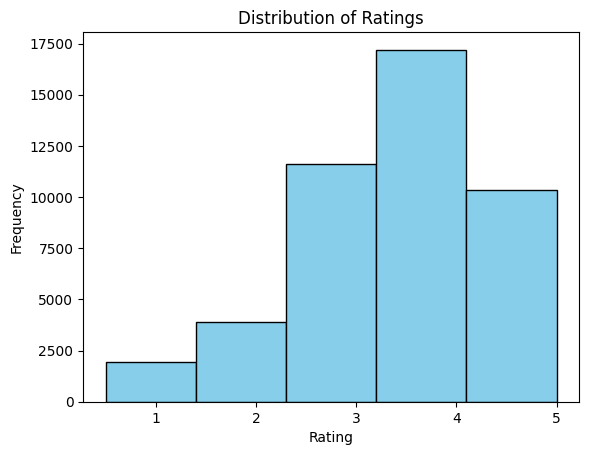

In [37]:
# Plot a histogram of ratings
plt.hist(movie_ratings['rating'], bins=5, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

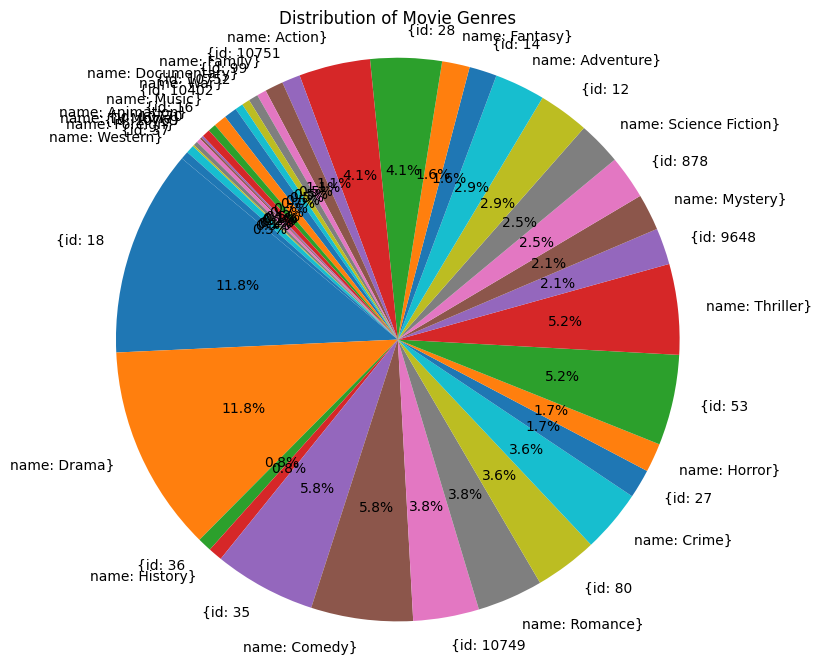

In [38]:
# Parse genre strings and count occurrences
genres_count = Counter()
for sublist in movie_ratings['genres']:
    genres = sublist.strip('[]').replace("'", "").split(', ')
    genres_count.update(genres)

# Plot a pie chart of movie genres
plt.figure(figsize=(8, 8))
plt.pie(genres_count.values(), labels=genres_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Movie Genres')
plt.axis('equal')
plt.show()


## Building the KNN model

In [87]:
# creating user-item matrix where users are listed on one side and movies on the other
user_movie_matrix = movie_ratings.pivot(index=['userId'], columns=['movieId'], values='rating').fillna(0)
user_movie_matrix

movieId,2,3,5,6,11,12,13,14,15,16,...,134158,134368,134569,134881,135536,140174,142507,148652,158238,160718
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Define a KNN model on cosine similarity
cf_knn_model= NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

# Fitting the model on our matrix
cf_knn_model.fit(user_movie_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

## Building the recommendation system

In [80]:
def movie_recommender_engine(movie_name, matrix, cf_model, n_recs): 
    # Extract input movie ID
    movie_id = movie_ratings[movie_ratings['title'] == movie_name]['movieId'].iloc[0]
    
    # Calculate neighbour distances
    distances, indices = cf_model.kneighbors(matrix.loc[movie_id].values.reshape(1, -1), n_neighbors=n_recs+1)
    movie_rec_ids = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    # List to store recommendations
    cf_recs = []
    for i in movie_rec_ids:
        cf_recs.append({'Title': movie_df['title'][i[0]], 'Distance': i[1]})
    
    # Select top number of recommendations needed
    df = pd.DataFrame(cf_recs, index=range(1, n_recs+1))
     
    return df


In [83]:
# Getting recommendations
n_recs = 10 # number of recommendation required
movie_name = 'Batman'
recommendations = movie_recommender_engine(movie_name, user_movie_matrix, cf_knn_model, n_recs)
print(recommendations)

                            Title  Distance
1                            Rudy  0.487272
2   Kids in the Hall: Brain Candy  0.481543
3                       Nico Icon  0.481070
4             I Like It Like That  0.471330
5           Farewell My Concubine  0.469866
6                     Black Sheep  0.464550
7                   Pushing Hands  0.455952
8                  Down Periscope  0.449715
9                  Heaven & Earth  0.445610
10                           Kika  0.437793
